In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.style.use( 'ggplot' ) 

In [2]:
import pandas 
from sklearn.preprocessing import MinMaxScaler
import numpy as np 
import pickle
from scipy.stats import pearsonr

# Feature sets 

This notebook collects the various feature sets from molecular modeling (in `*runs/*/feature_set.csv'`), and matches them up with the various targets (for now, melting temperature, turnover number, substrate affinity, and efficiency) for input to machine learning algorithms

In [3]:
feature_sets = [ 
    # rosetta 
    '../rosetta_runs/benchmark/feature_set.csv', 
    '../rosetta_runs/shells/feature_set.csv',
    '../rosetta_runs/ddg_monomer/feature_set.csv', 
    '../rosetta_runs/new_protocol/feature_set.csv', 
    
    # pyrosetta 
    '../pyrosetta_runs/beta/feature_set.csv', 
    '../pyrosetta_runs/beta2/feature_set.csv', 
    
    # foldx 
    '../foldx_runs/pssm/feature_set.csv', 
    
    # dreaming 
    # '../rosetta_runs/homology_models/feature_set.csv', 
]

In [4]:
#experimental_data 
dat = pandas.read_csv( '../data_sets/experimental/targets.csv', index_col=0 )
#dat.kcat = np.log10( dat.kcat / 880 )
#dat.km = np.log10( dat.km / 5.5 )
#dat.kcatkm = np.log10( dat.kcatkm / 174000 )
#dat = dat.replace( [ np.inf, -np.inf ], -5 )

In [5]:
dat.sample( 6 ) 

expression    tm      kcat        km    kcatkm
mutant                                                
Y294F            1  0.83 -0.078195 -0.078457 -0.151524
H119A            1  0.30 -0.789147 -0.480007 -1.263603
T15A             1 -0.76 -0.156314 -0.025306 -0.176657
W399A            1   NaN       NaN       NaN -4.240549
W120H            1  0.16 -1.020203 -1.251297 -2.266038
E353A            1   NaN       NaN       NaN -4.240549

In [6]:
targets = [ 'kcat', 'km', 'kcatkm', 'tm', 'expression' ] 

In [7]:
combos = []
for feature_set in feature_sets:
    
    # read in feature set 
    feats = pandas.read_csv( feature_set, index_col=0 )
    # short name for display 
    name = feature_set.split( '/' )[2]
    
    # join feature sets with targets 
    for target in targets:
        
        # join feature set with target and remove rows and columns with NaN entries 
        J = dat[[ target ]].join( feats ).dropna()
        print( J.shape, name, target )
        
        # calculate feature correlation to target while this is still a DataFrame
        corr_to_target = J.corr()[ target ].drop( target )  # pandas.Series 
        
        # scale the features to the [0,1] interval 
        scaler = MinMaxScaler()
        X = scaler.fit_transform( J )
        
        # get all columns except first one (first is target col) 
        X = X[ : , 1: ] 
        
        # reshape target to a 1-D array for sklearn 
        y = J.ix[ : , 0 ].ravel()
        
        # append a combo tuple 
        # include names of columns since the scaler returns an unlabeled NumPy array 
        support = J.columns[ 1: ] # feature names 
        combos.append( ( name, target, X, y, support, corr_to_target ) )

(73, 60) benchmark kcat
(73, 60) benchmark km
(87, 60) benchmark kcatkm
(76, 60) benchmark tm
(125, 60) benchmark expression
(74, 60) shells kcat
(74, 60) shells km
(85, 60) shells kcatkm
(77, 60) shells tm
(123, 60) shells expression
(73, 15) ddg_monomer kcat
(73, 15) ddg_monomer km
(88, 15) ddg_monomer kcatkm
(76, 15) ddg_monomer tm
(127, 15) ddg_monomer expression
(74, 60) new_protocol kcat
(74, 60) new_protocol km
(86, 60) new_protocol kcatkm
(77, 60) new_protocol tm
(124, 60) new_protocol expression
(73, 27) beta kcat
(73, 27) beta km
(85, 27) beta kcatkm
(76, 27) beta tm
(122, 27) beta expression
(73, 27) beta2 kcat
(73, 27) beta2 km
(85, 27) beta2 kcatkm
(76, 27) beta2 tm
(122, 27) beta2 expression
(74, 17) pssm kcat
(74, 17) pssm km
(89, 17) pssm kcatkm
(77, 17) pssm tm
(128, 17) pssm expression


In [8]:
with open( 'combos.pkl', 'wb' ) as fn:
    pickle.dump( combos, fn ) 

## Feature distributions

Here, we attempt to make a compact representation of the feature ranges in the feature set. Each plot is titled with the feature set name and target name (each feature set has different mutants in it, depending on the target). Each feature has been normalized to the [0,1] interval. The number in parentheses after the feature name is the Pearson correlation coefficient for the individual feature to the target.

/usr/local/bin/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


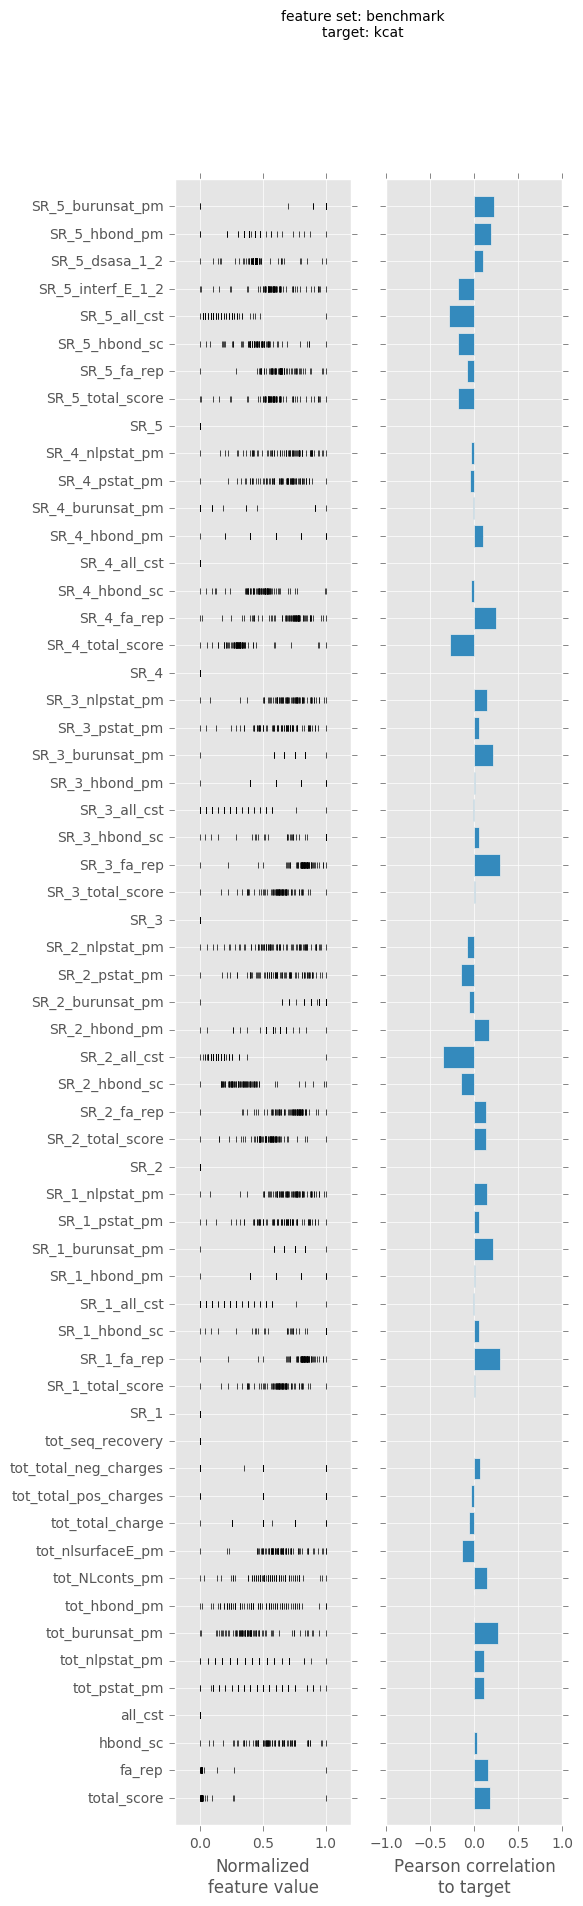

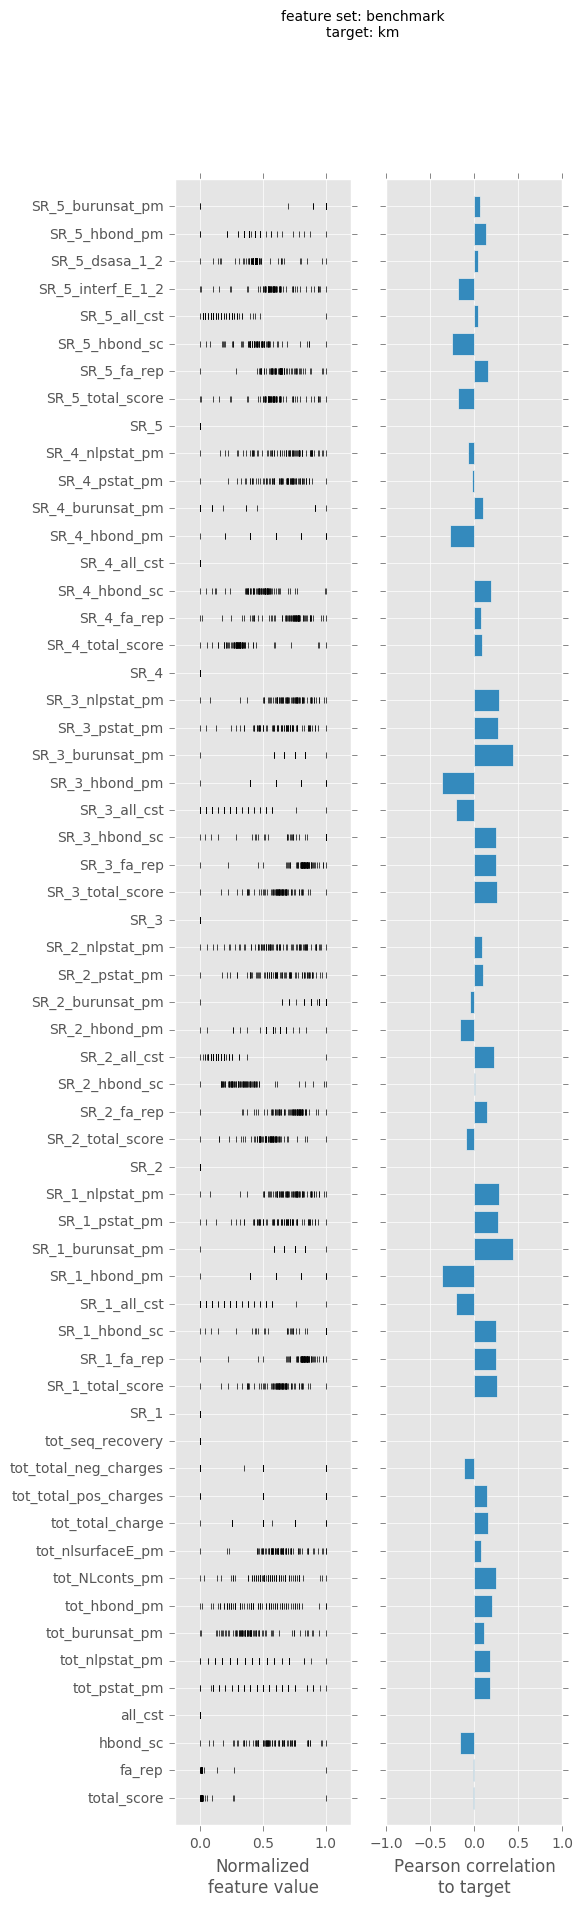

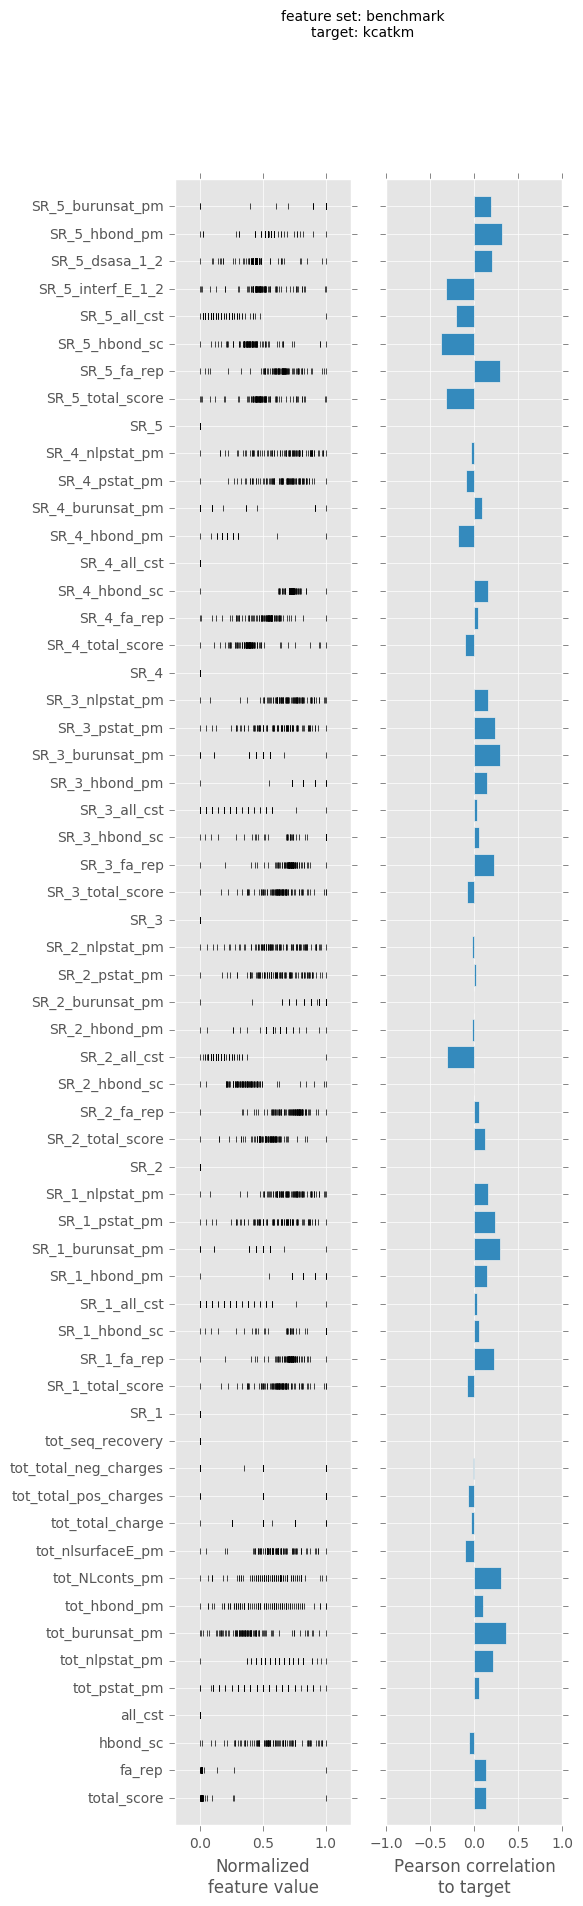

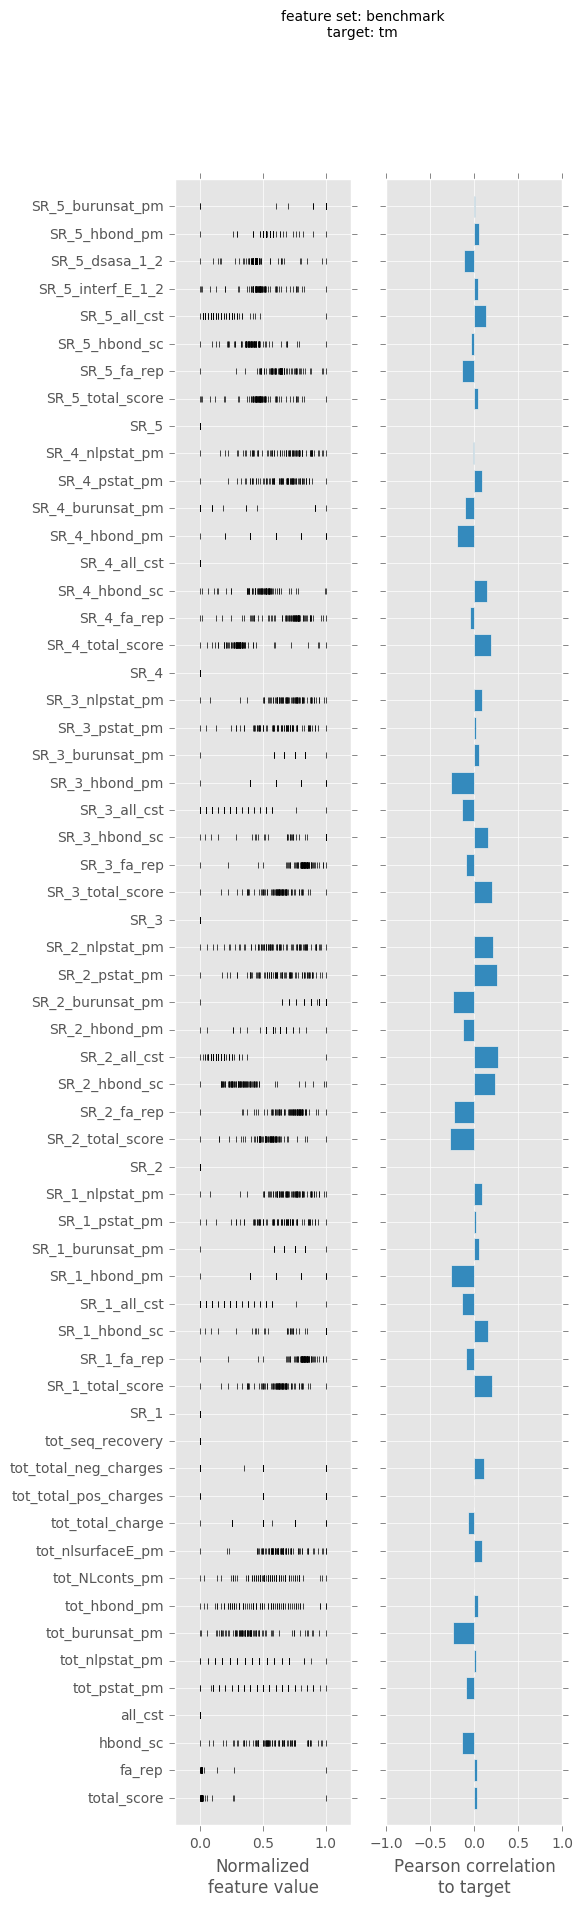

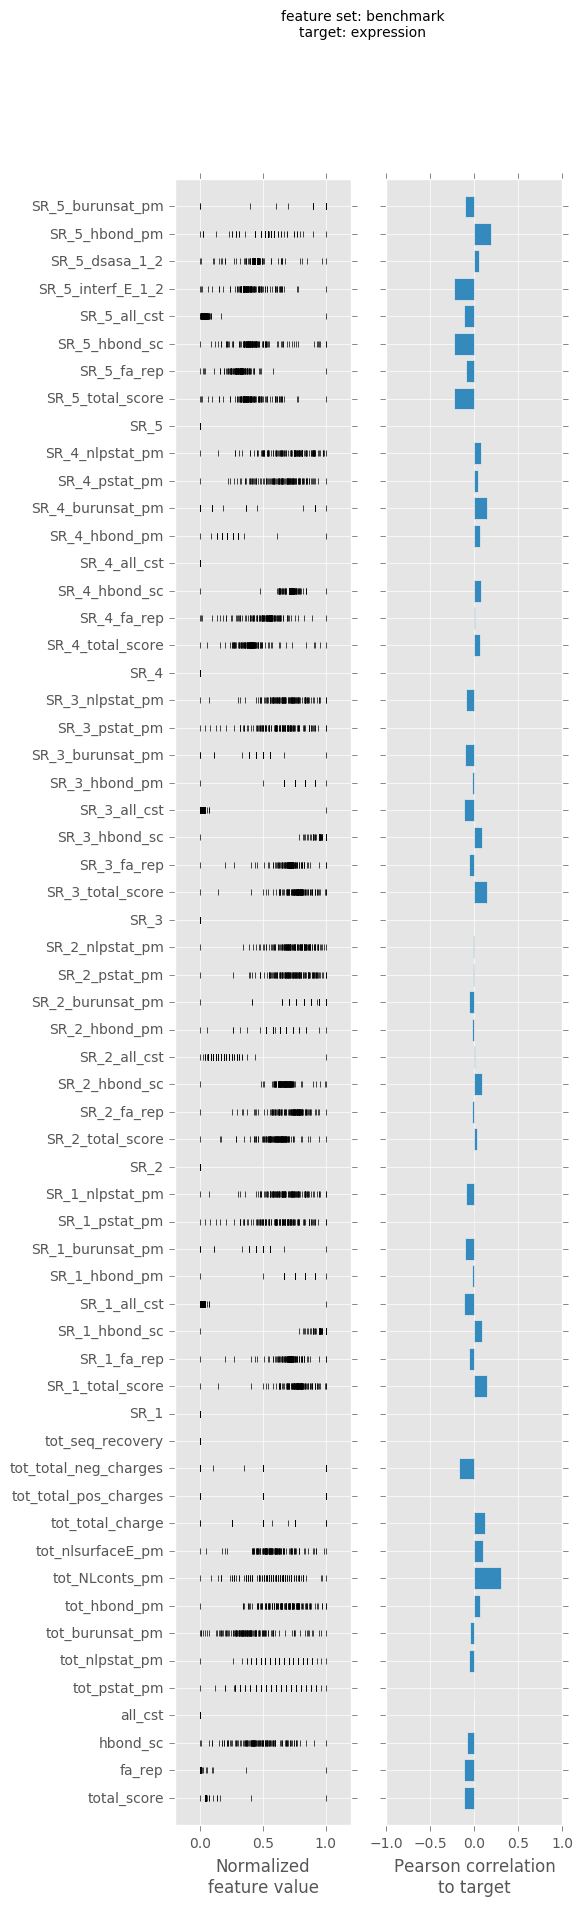

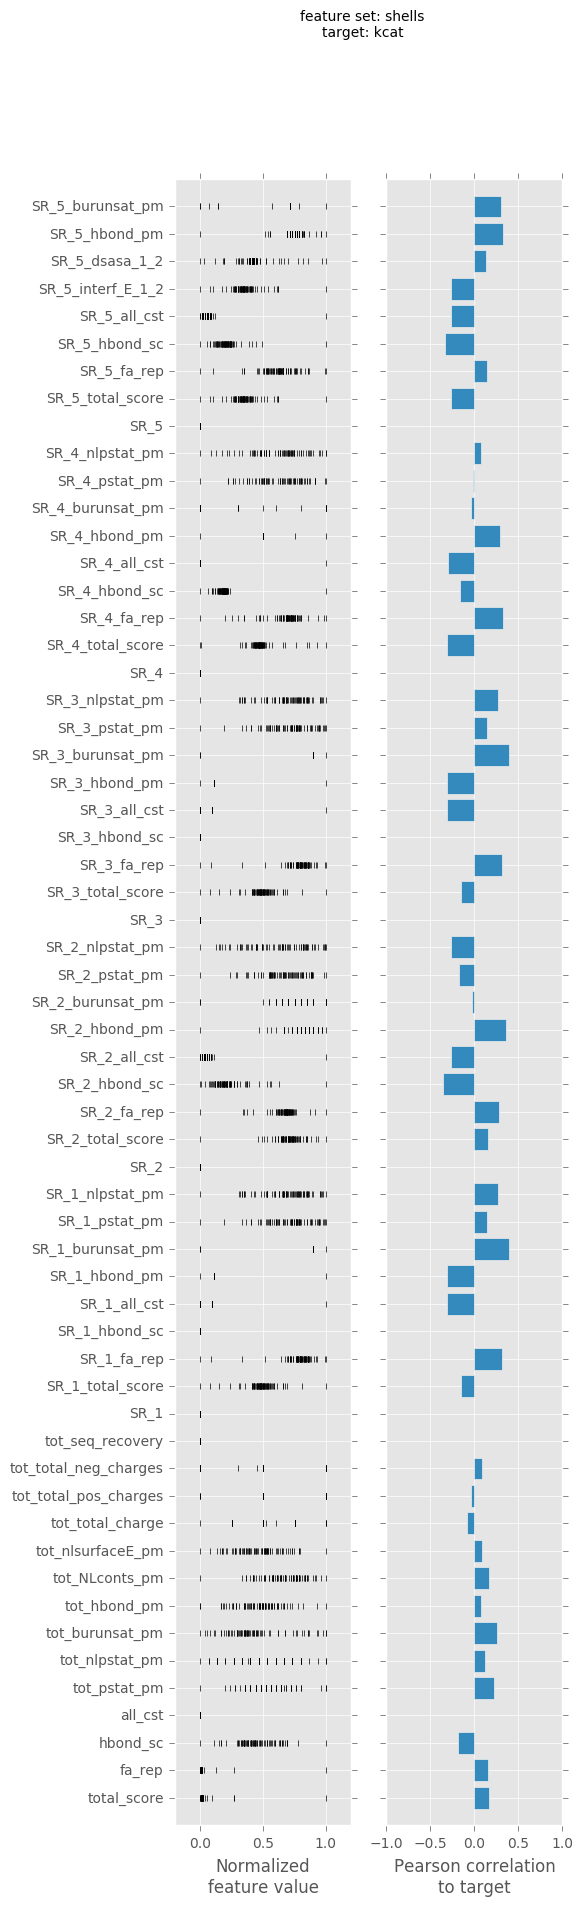

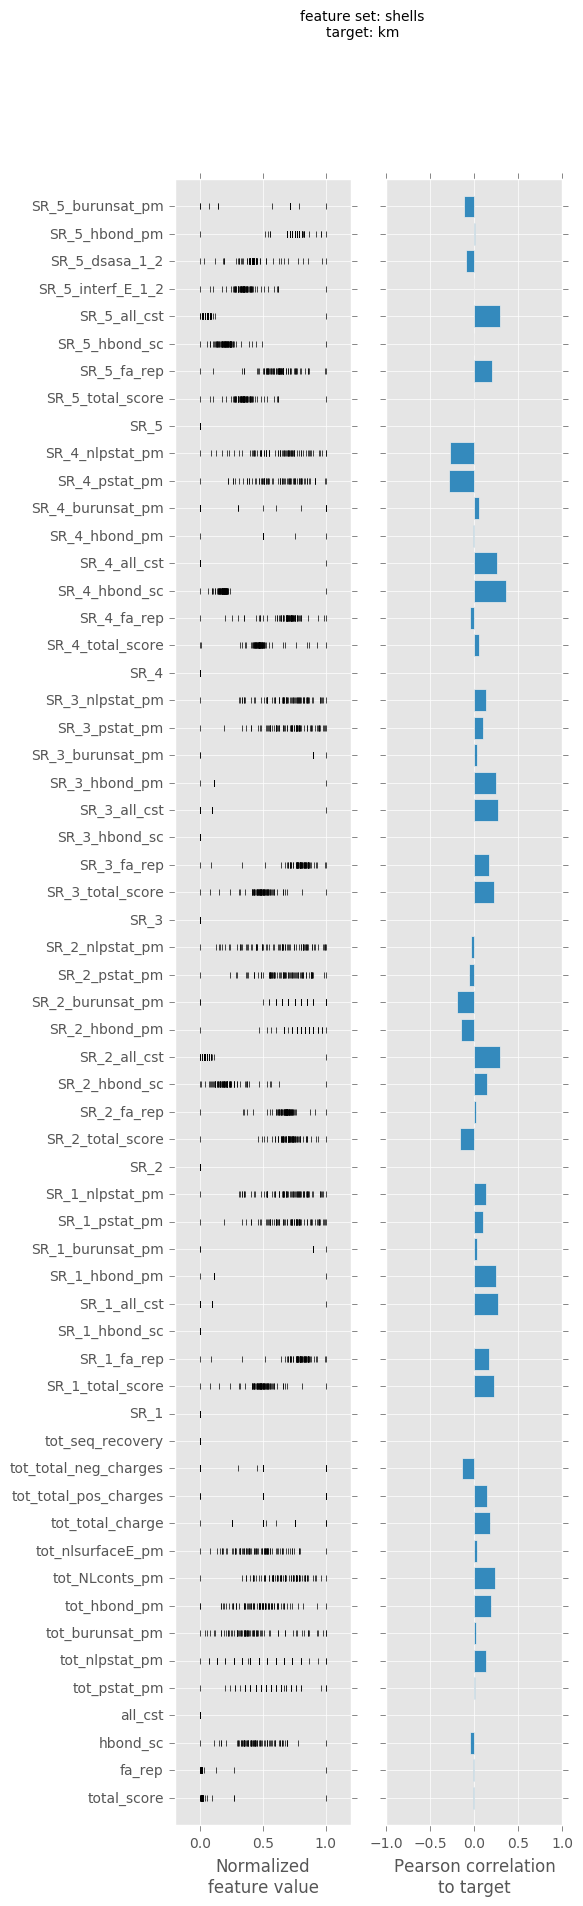

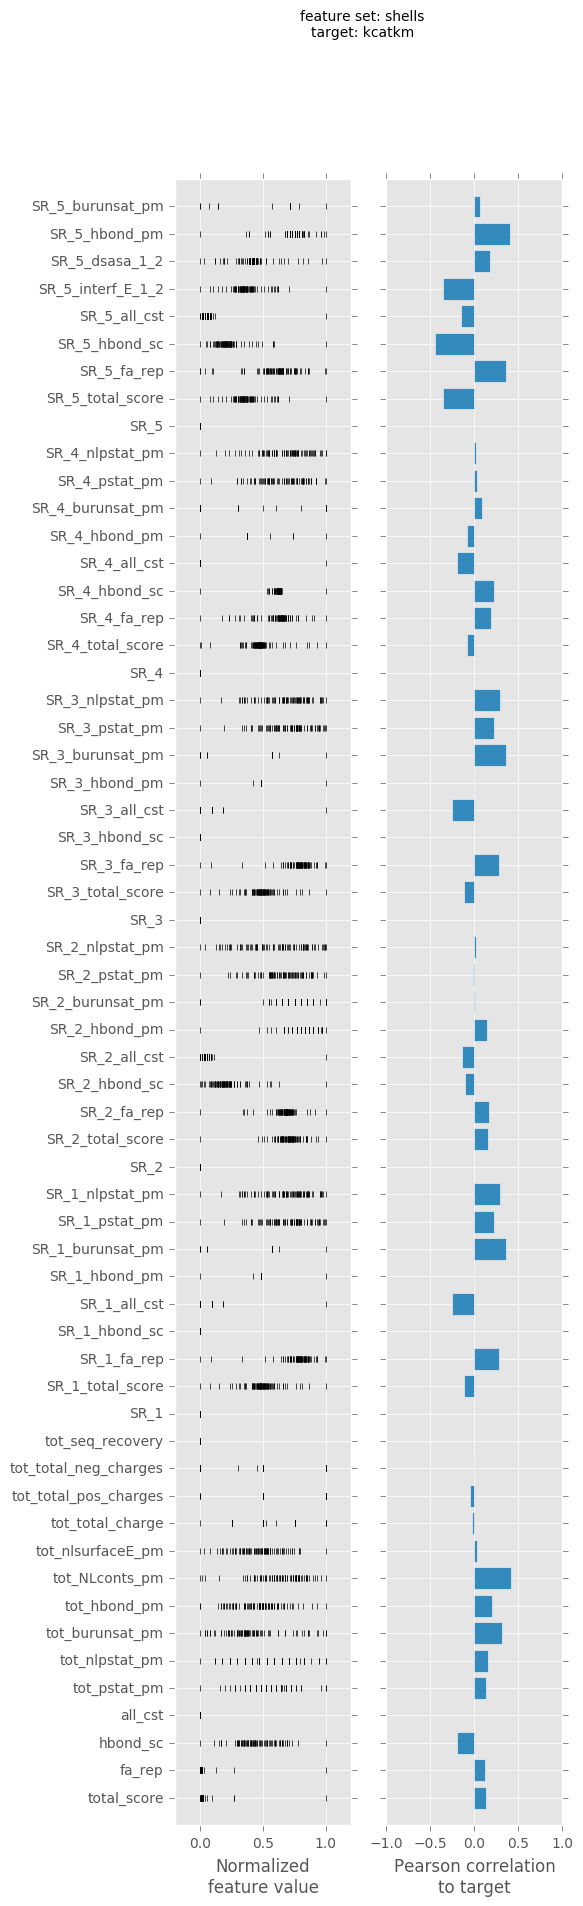

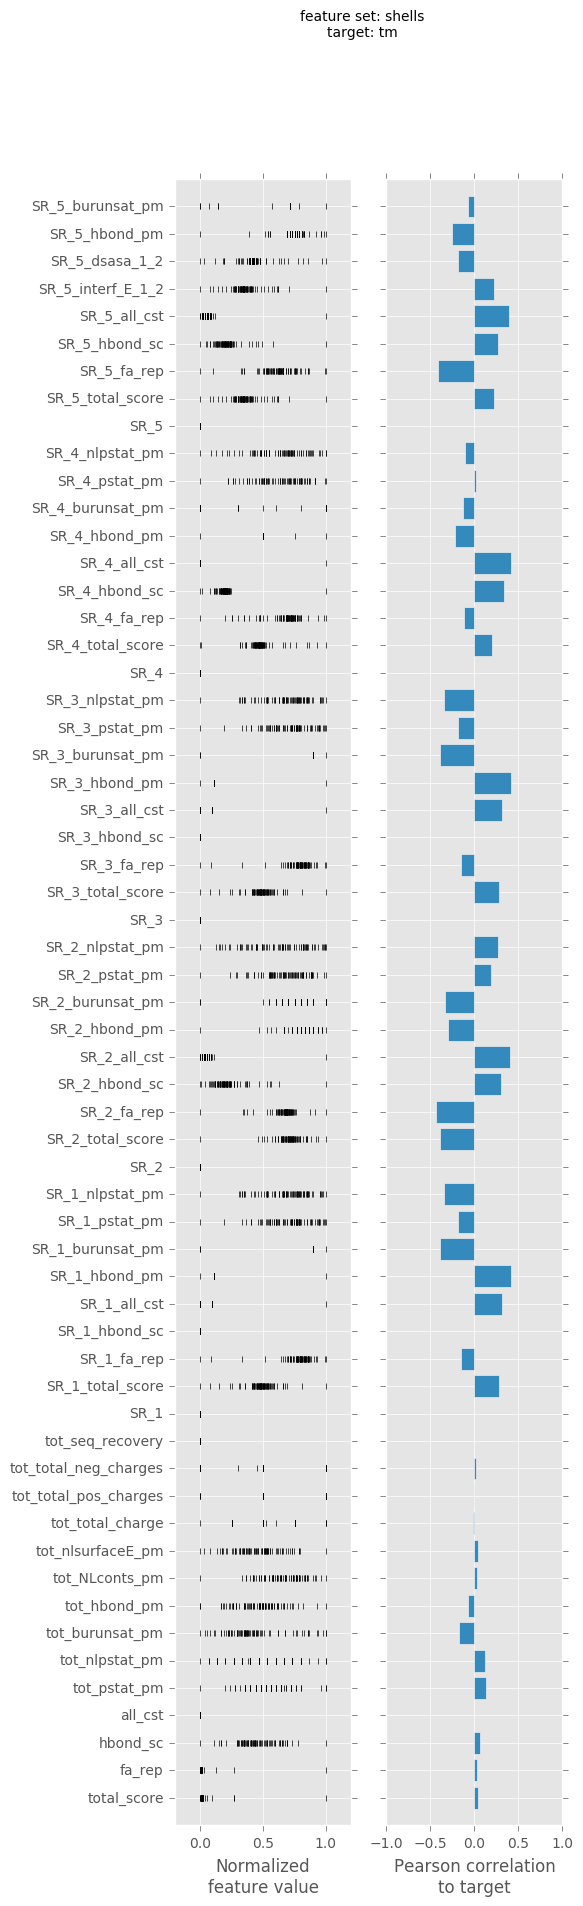

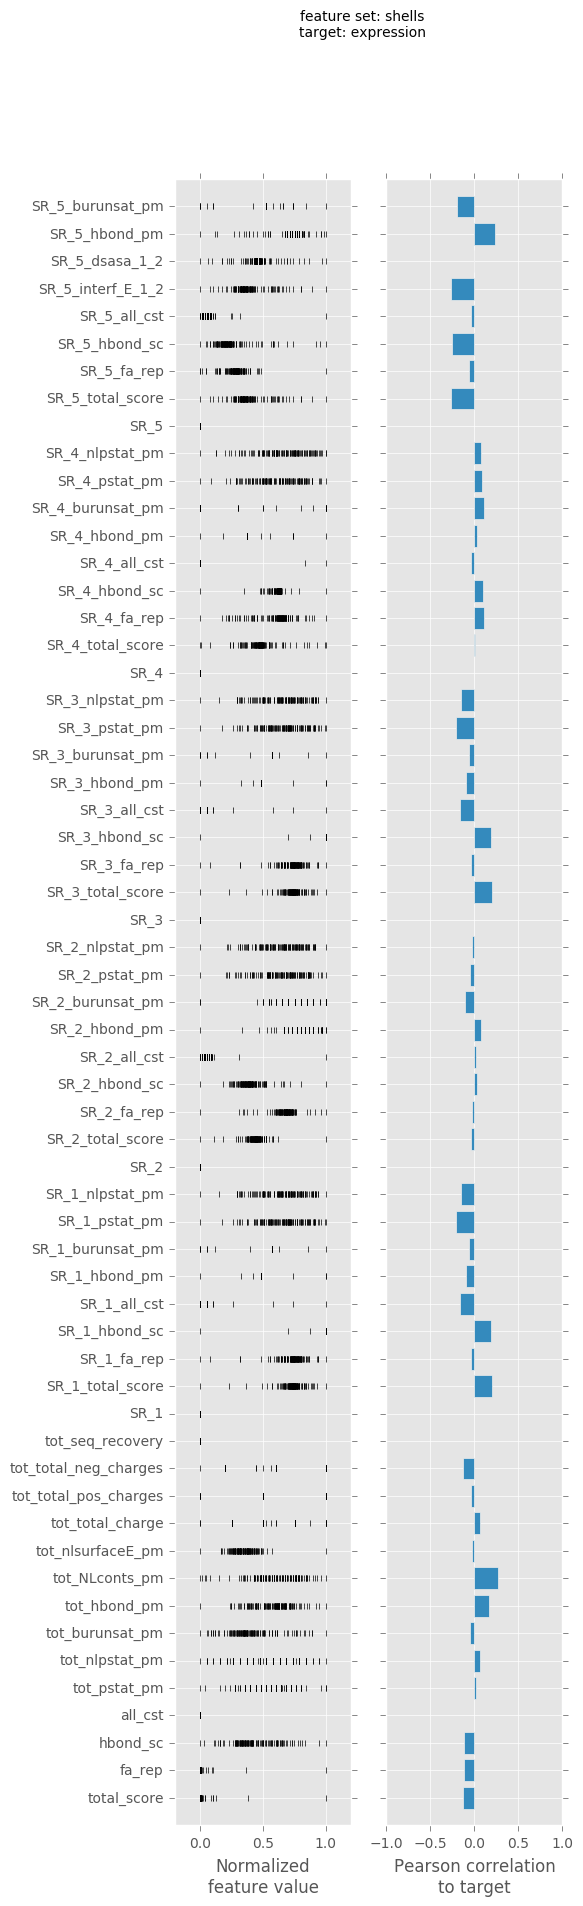

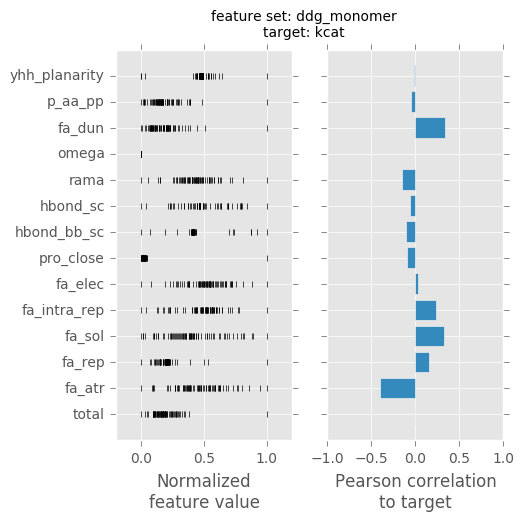

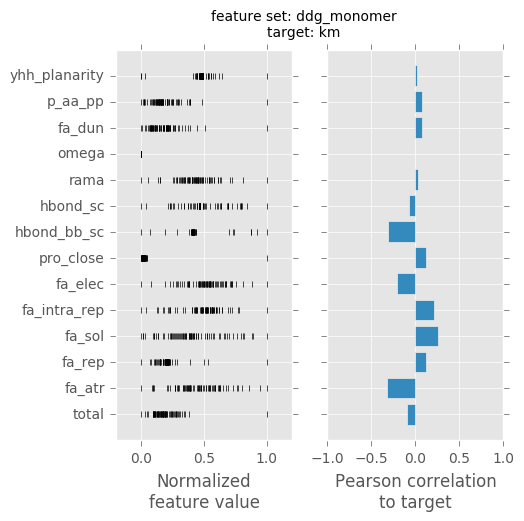

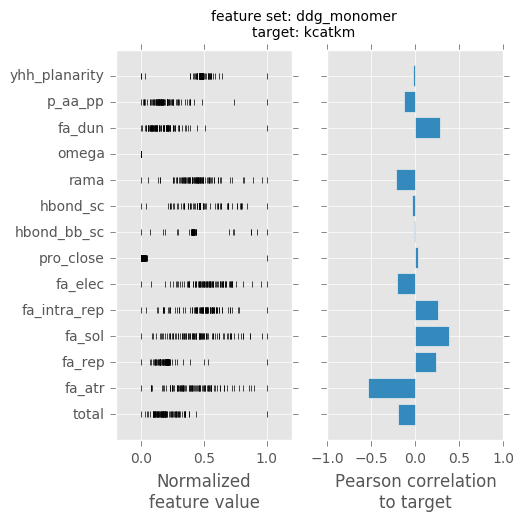

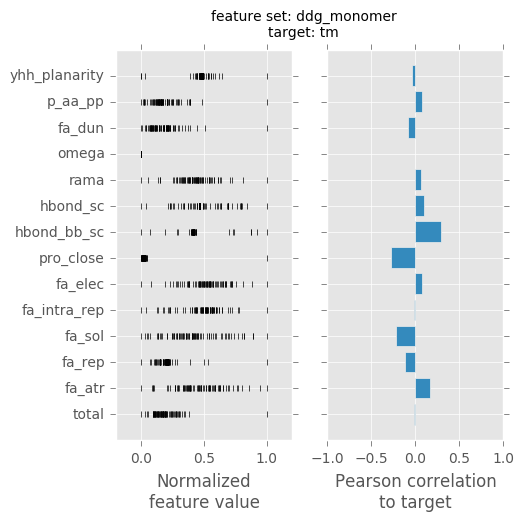

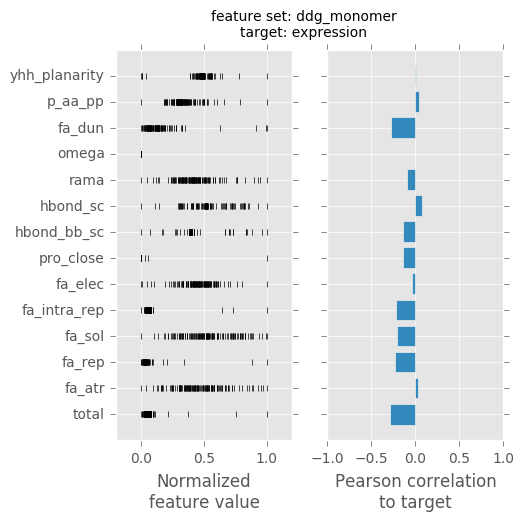

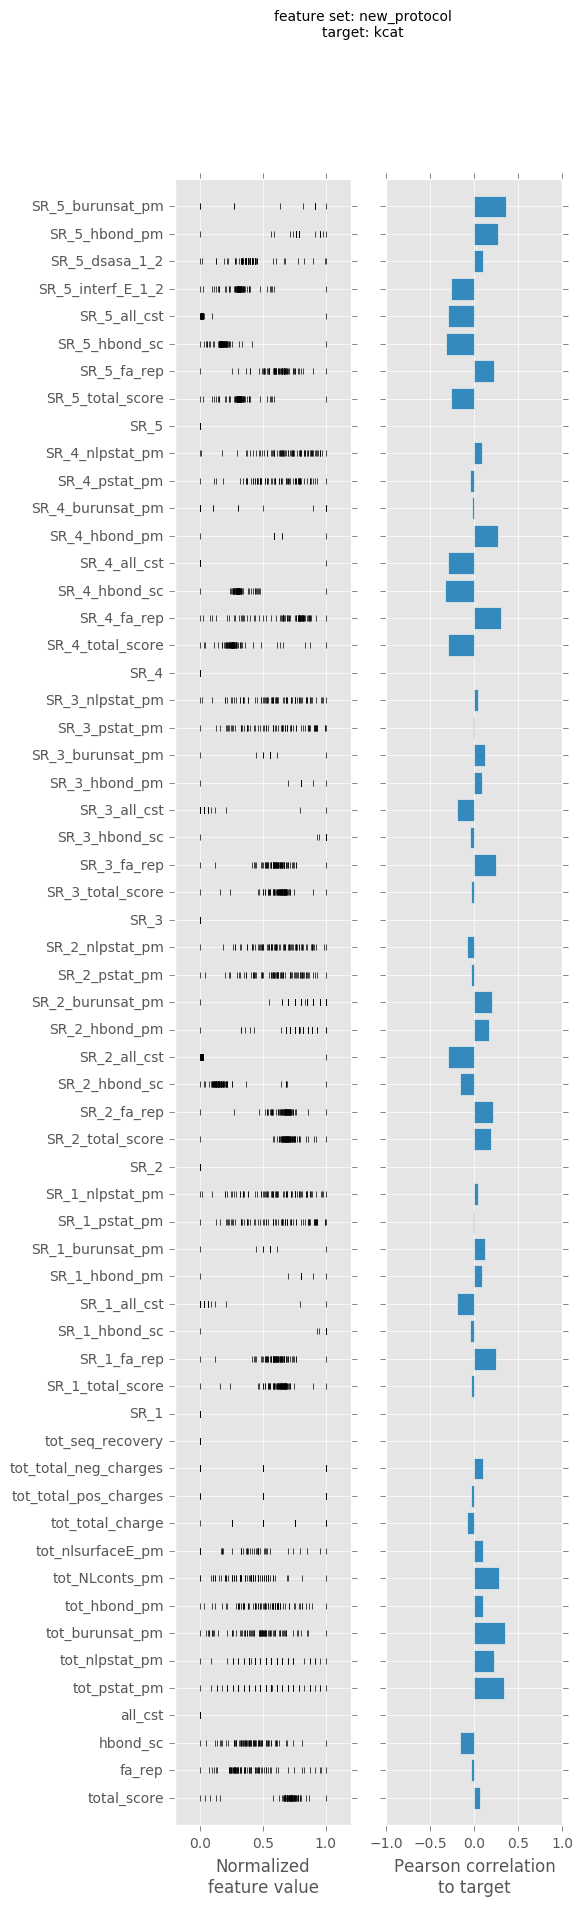

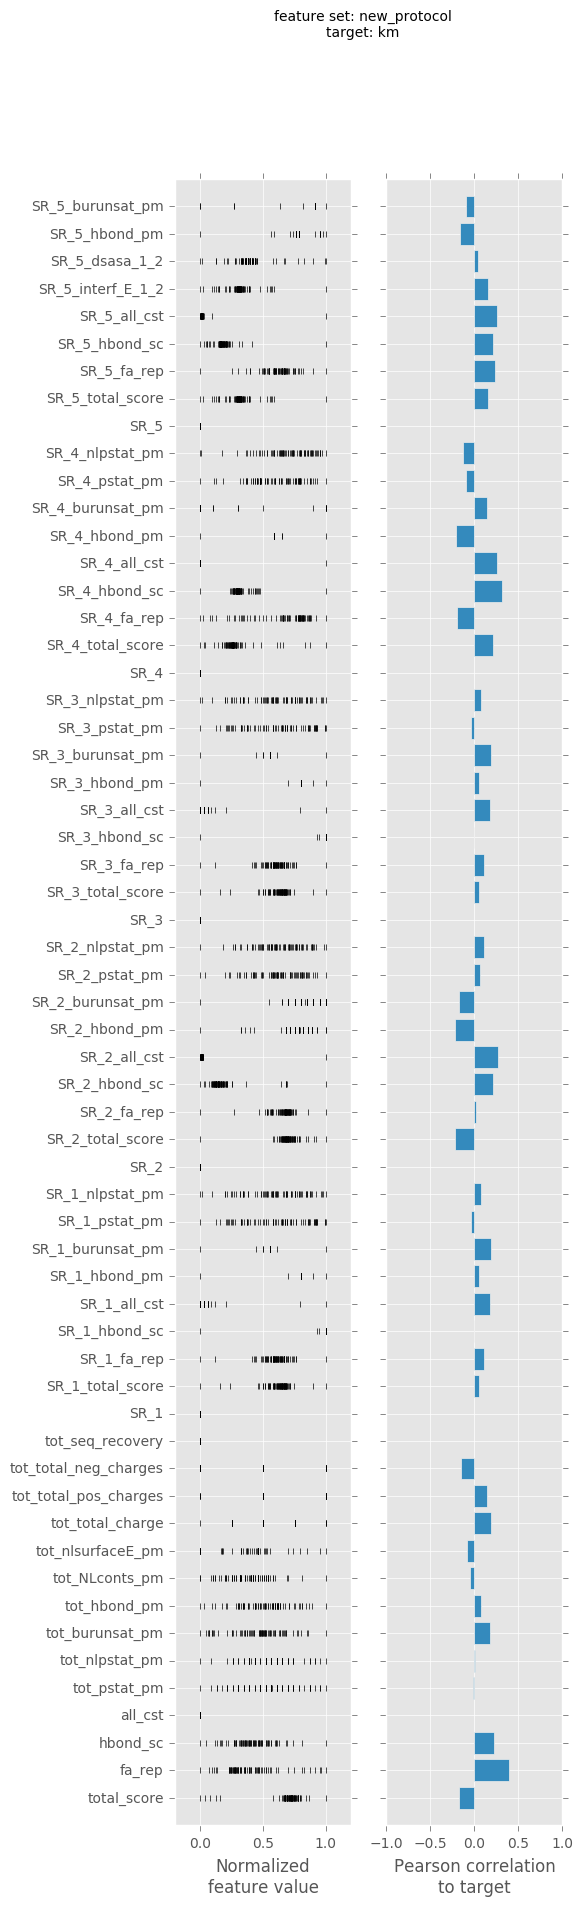

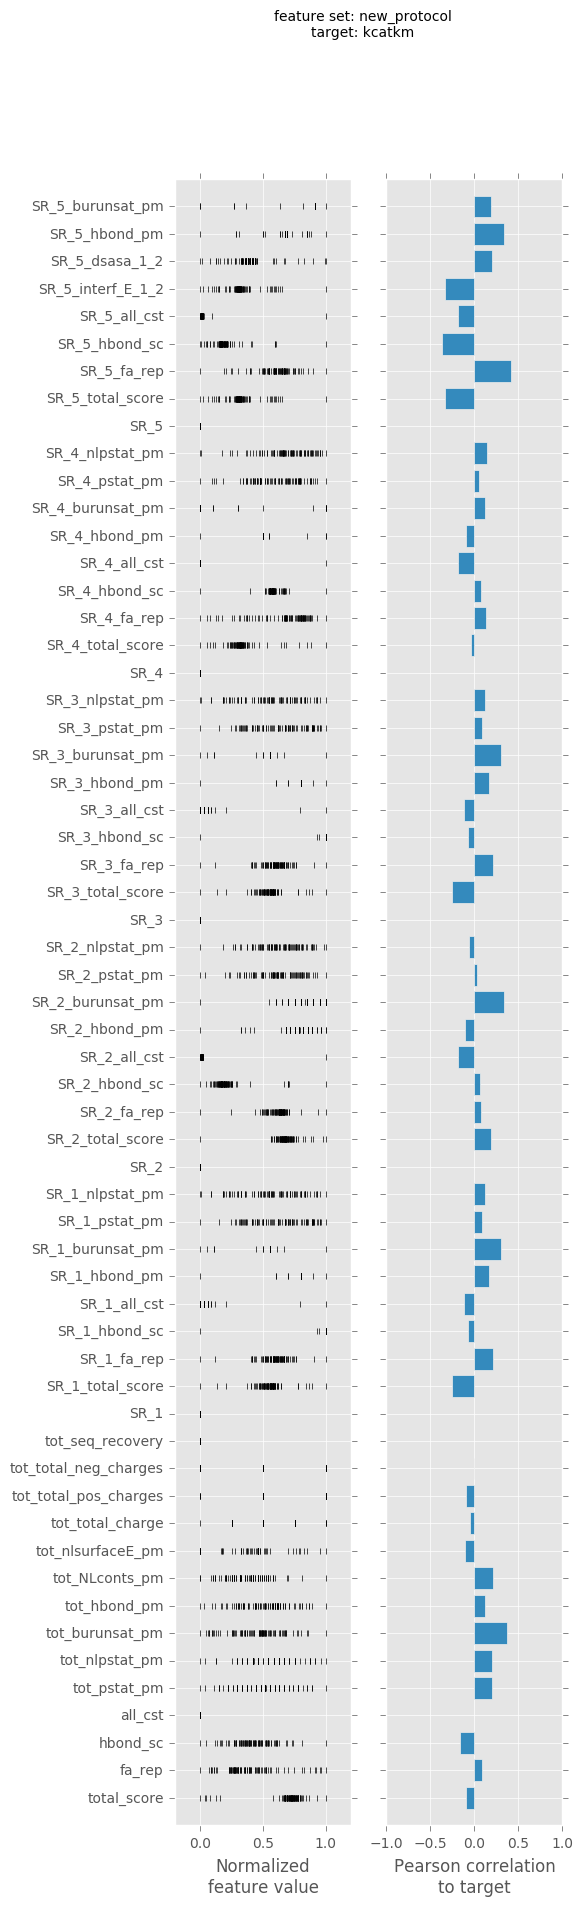

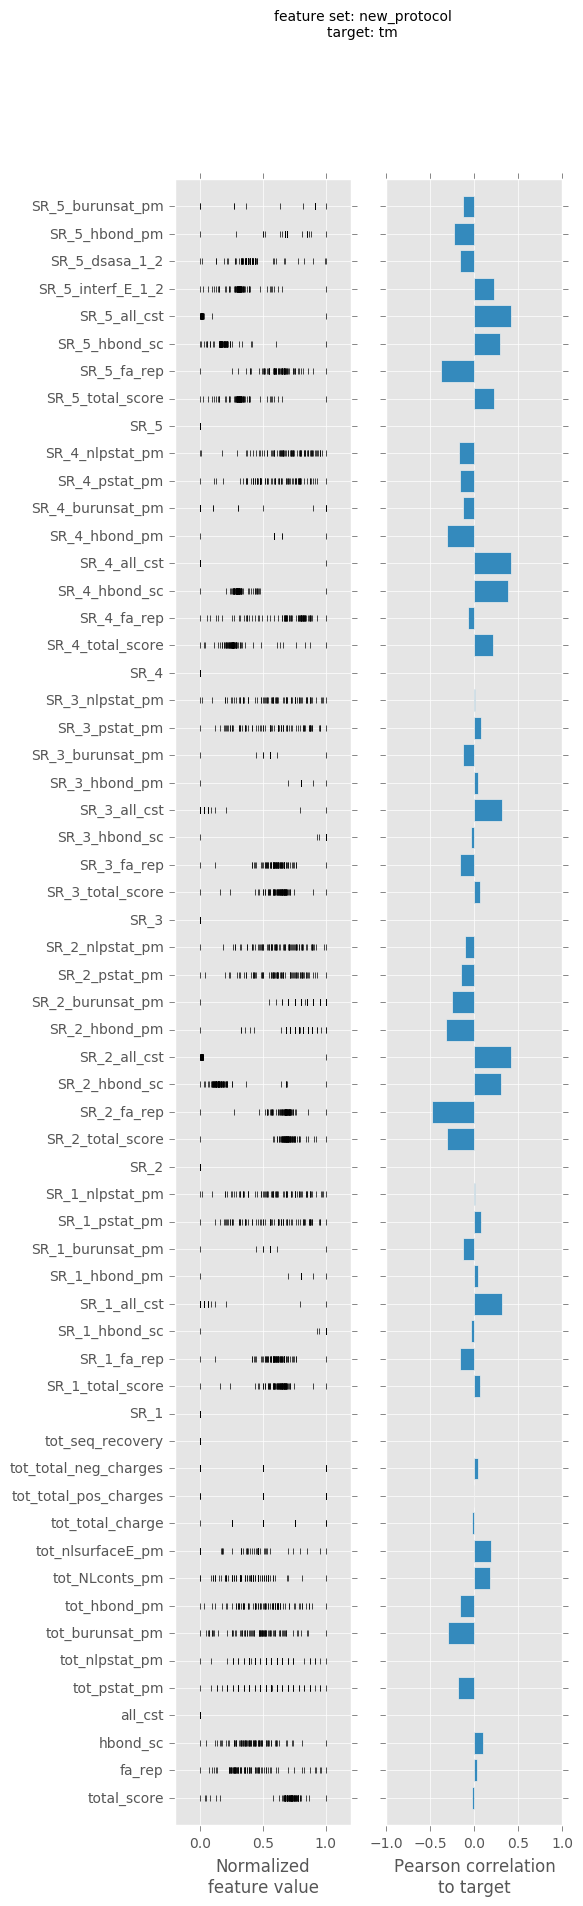

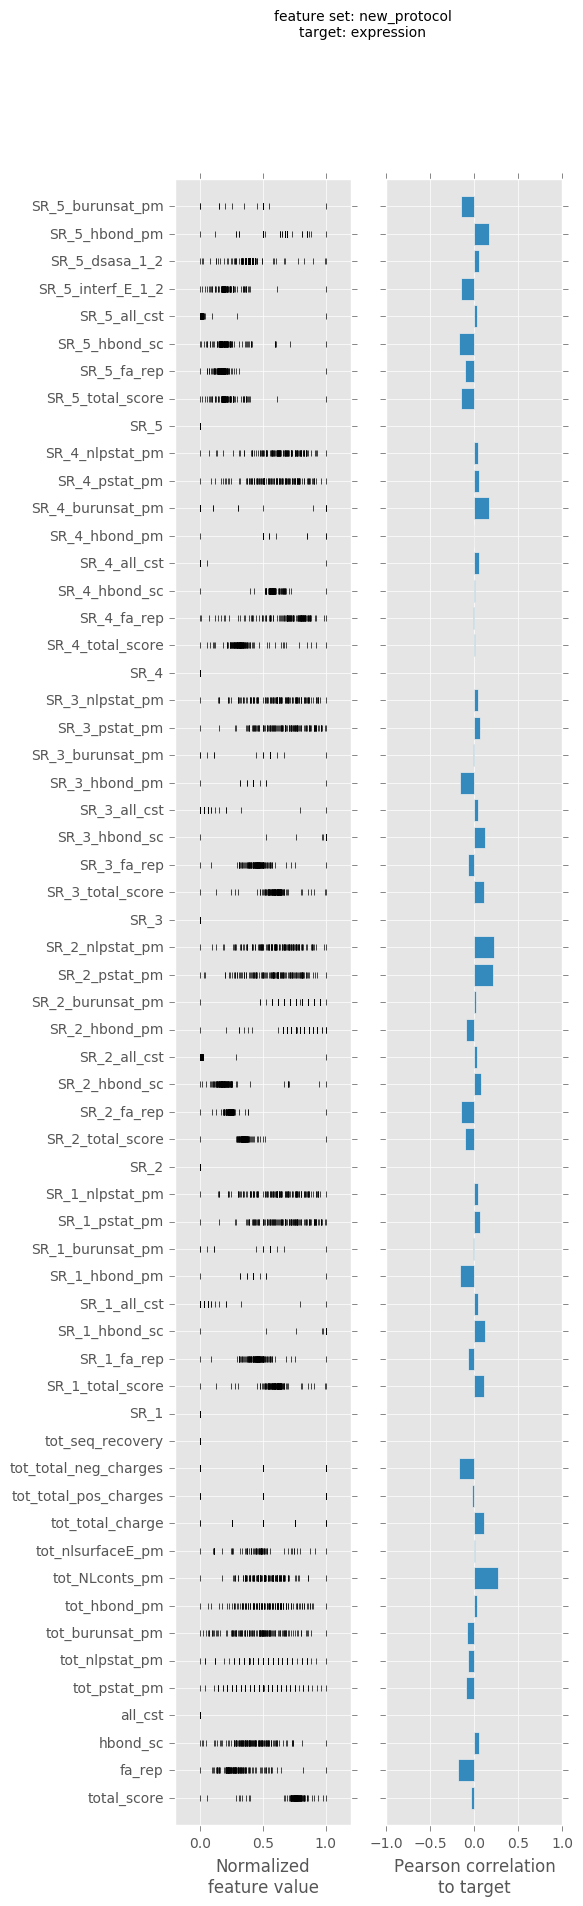

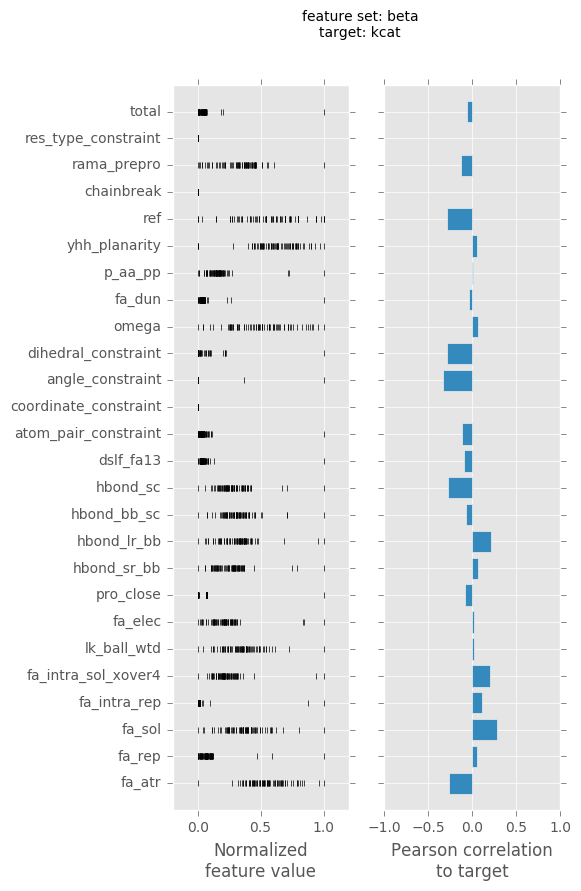

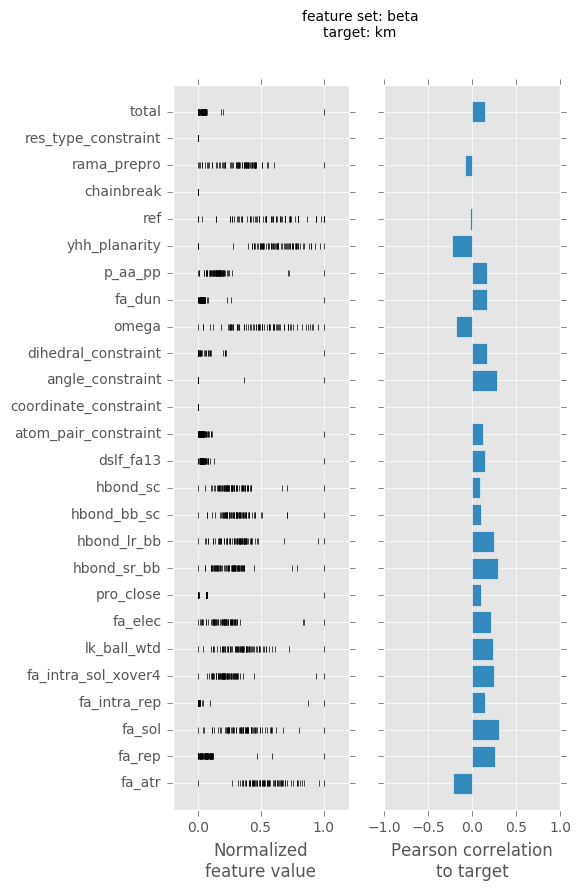

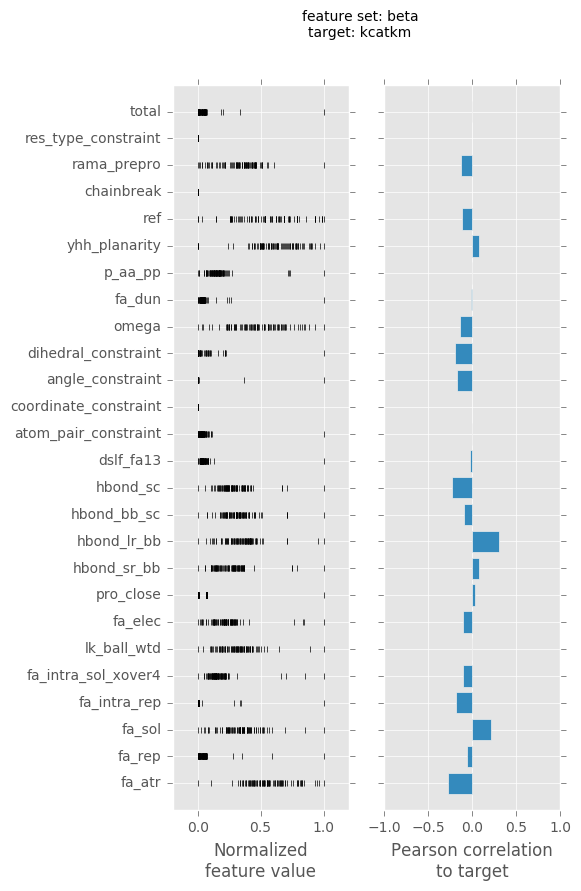

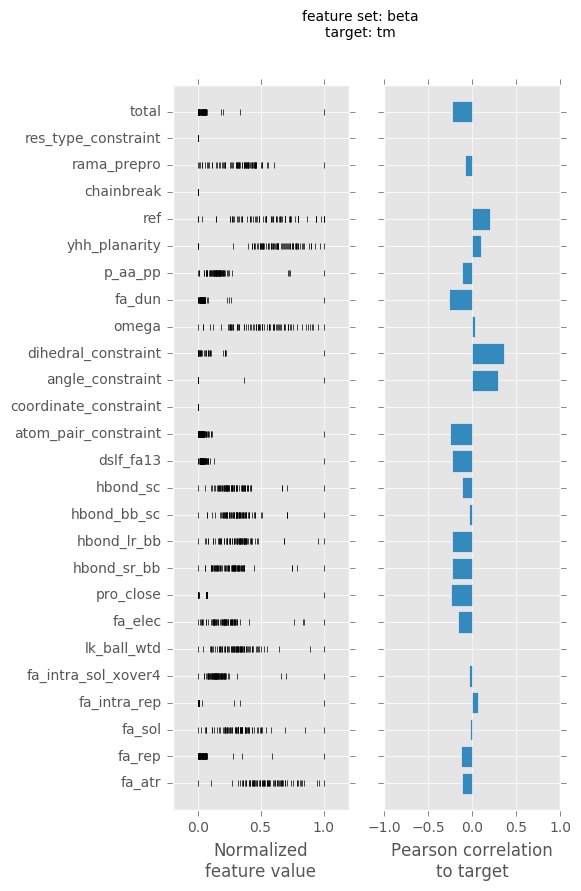

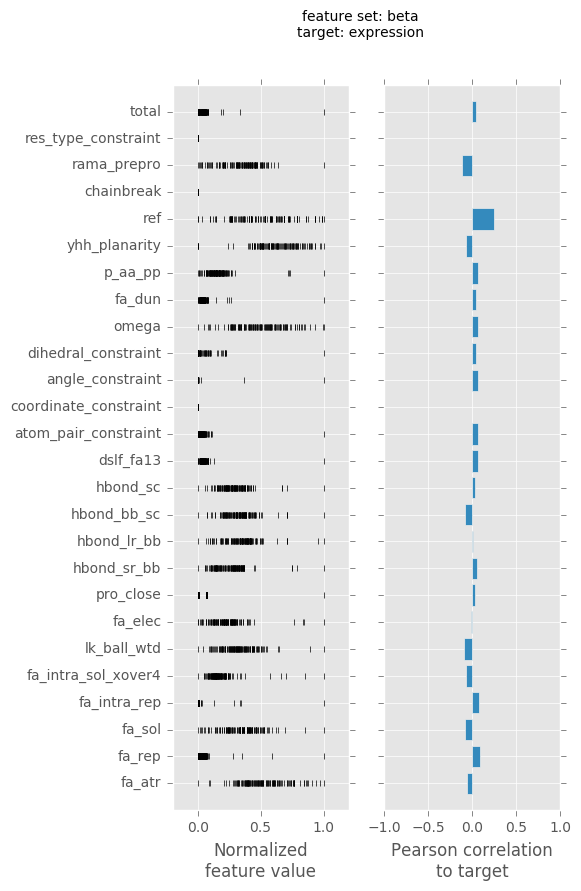

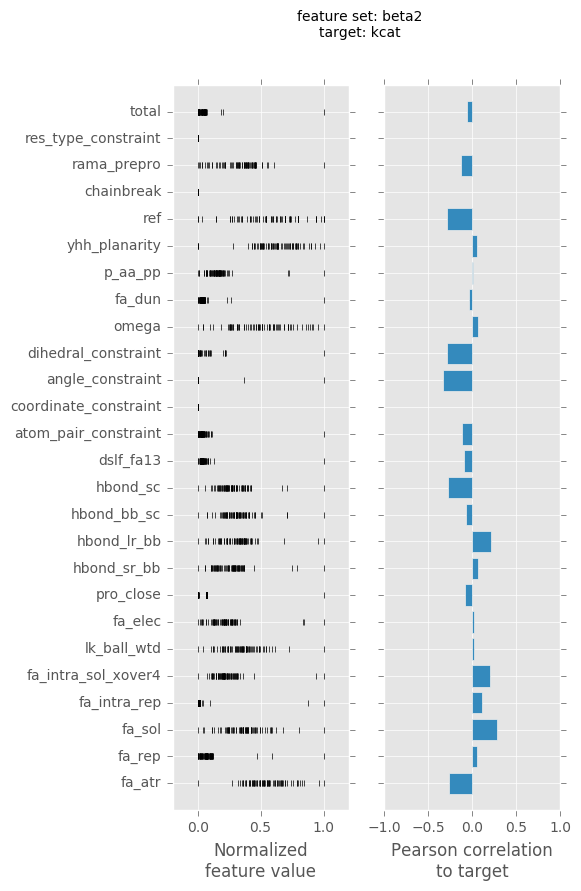

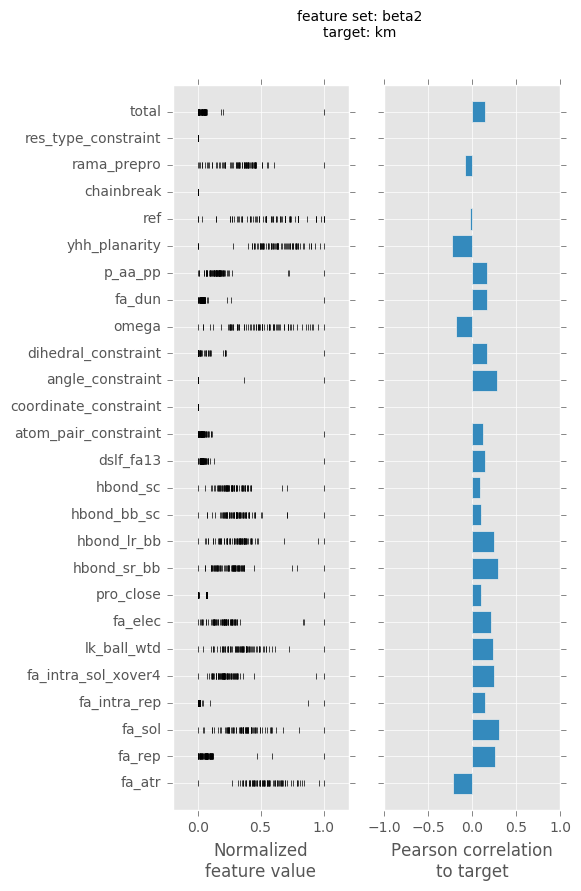

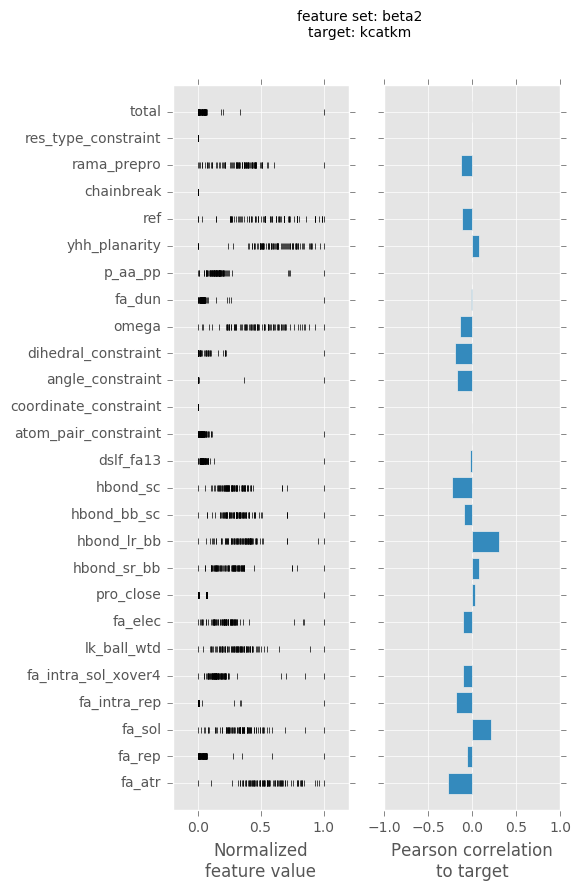

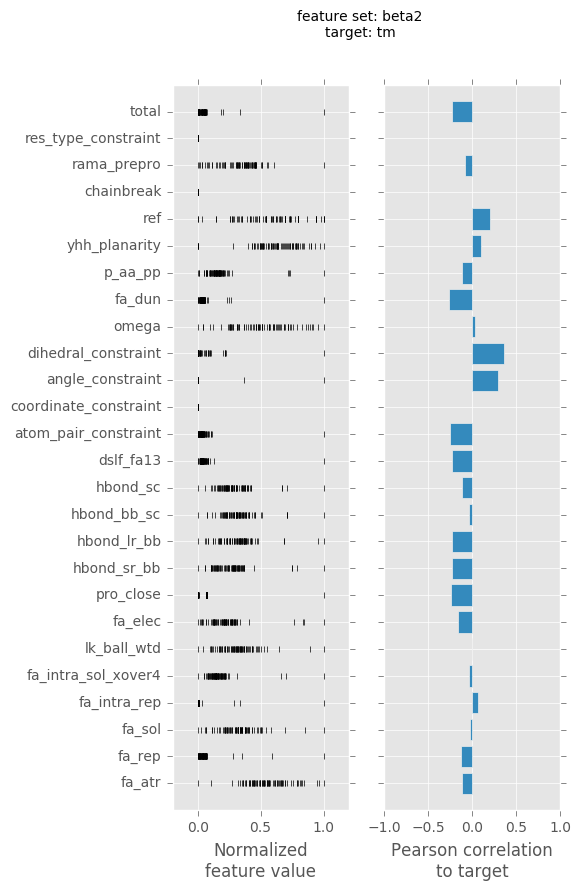

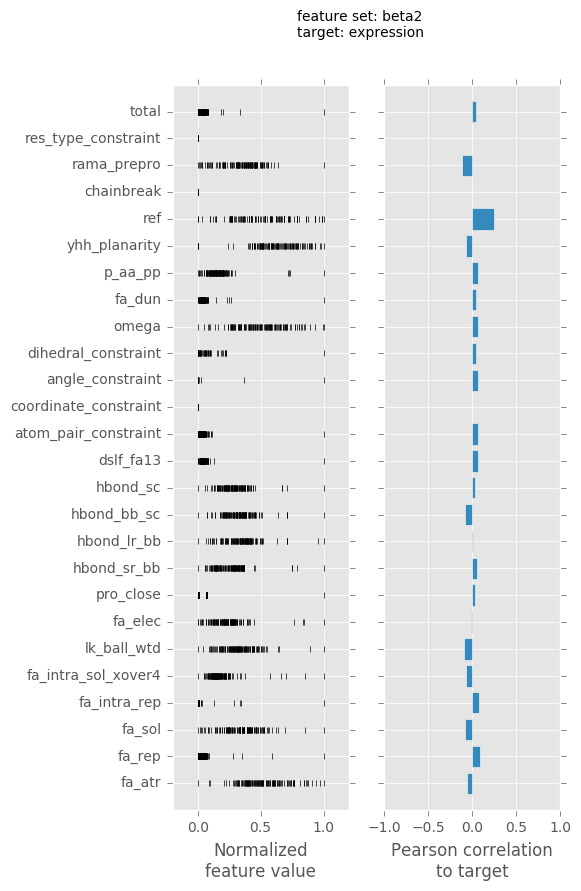

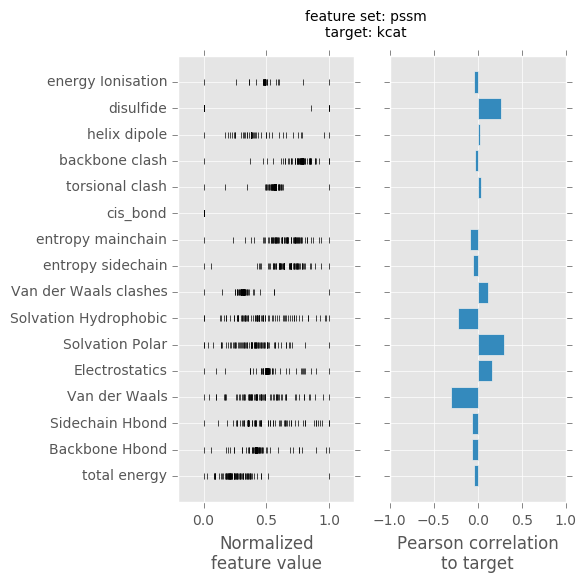

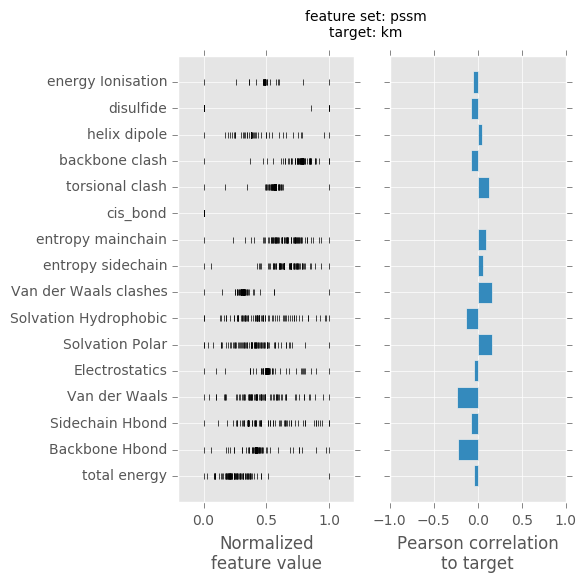

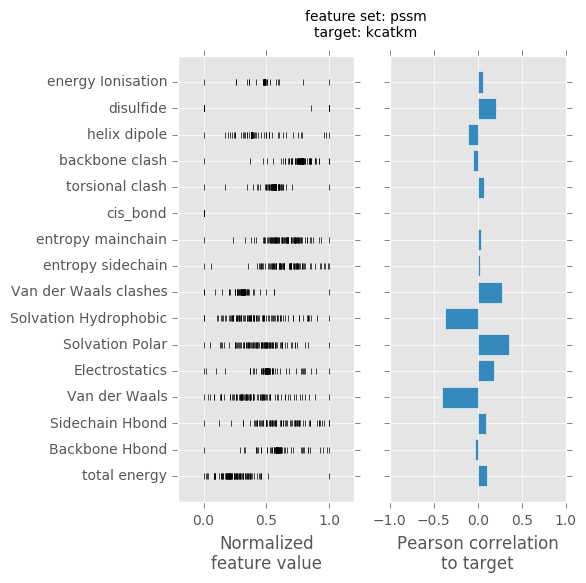

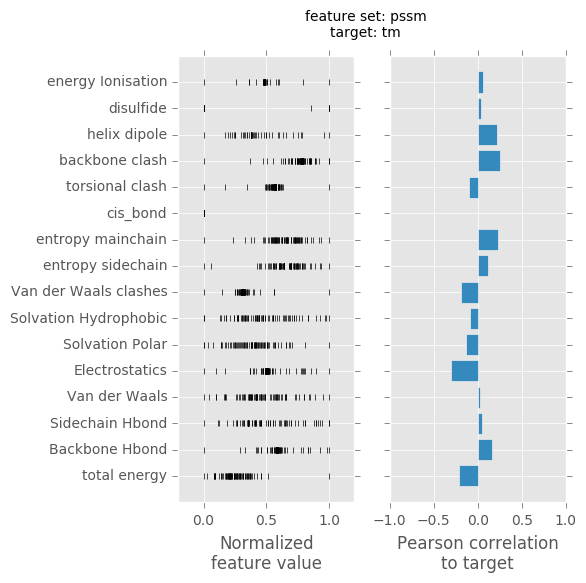

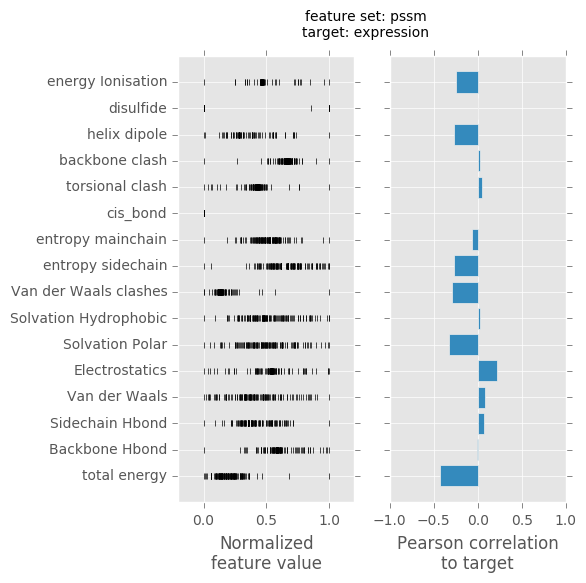

In [9]:
for name, target, X, y, support, corr_to_target in combos: 
    
    fig, ax = plt.subplots( nrows=1, ncols=2, sharey=True, figsize=( 5, 0.36 * len( support ) ) )
        
    support_vals = []
    rr = []
    for i, col_name in enumerate( support ):
        ax[ 0 ].scatter( X[ : , i ], [ i ] * len( X ), marker='|', color='k' )
        ax[ 0 ].set_ylim( -1, len( support ) )
        r, p = pearsonr( X[ : , i ], y )
        rr.append( r ) 
        #support_vals.append( '{} ({})'.format( col_name, r.round(2) ) )
        support_vals.append( '{}'.format( col_name ) )
        
    ax[ 0 ].set_yticks( range( len( support_vals ) ) )
    ax[ 0 ].set_yticklabels( support_vals )
    ax[ 0 ].set_xticks( ( 0, .5, 1 ) )
    ax[ 0 ].set_xlabel( 'Normalized\nfeature value' )
    
    ax[ 1 ].barh( range( len( support_vals ) ), rr, align='center' ) 
    ax[ 1 ].set_xlim( ( -1, 1 ) )
    ax[ 1 ].set_xlabel( 'Pearson correlation\nto target' )
    
    fig.suptitle( 'feature set: {}\ntarget: {}'.format( name, target ) )

## Single feature correlations

We will assess the correlation of each feature independent of the others to the given target. Then, we will make a scatter plot of that feature against the variable. We will do this for all the possible combinations of feature sets and targets. 

In [10]:
support

Index(['total energy', 'Backbone Hbond', 'Sidechain Hbond', 'Van der Waals',
       'Electrostatics', 'Solvation Polar', 'Solvation Hydrophobic',
       'Van der Waals clashes', 'entropy sidechain', 'entropy mainchain',
       'cis_bond', 'torsional clash', 'backbone clash', 'helix dipole',
       'disulfide', 'energy Ionisation'],
      dtype='object')

In [11]:
for name, target, X, y, support, corr_to_target in combos:
    
    top = corr_to_target.sort_values().head(1)
    bottom = corr_to_target.sort_values(ascending=False).head(1)
    
    top_info = [ top.values[0], top.name ] 
    bottom_info = [ bottom.values[0], bottom.name ] 
    
        
    #fig, ax = plt.subplots( nrows=1, ncols=2 ) #, sharey=True, figsize=( 5, 0.36 * len( support ) ) )
    
    #, fuck recreate dataframe 
    df = pandas.DataFrame( X, columns=support ) 
    #ax[0].scatter( df[ top.name ], df[ bottom.name ] ) 
#     support_vals = []
#     rr = []
#     for i, col_name in enumerate( support ):
#         ax[ 0 ].scatter( X[ : , i ], [ i ] * len( X ), marker='|', color='k' )
#         ax[ 0 ].set_ylim( -1, len( support ) )
#         r, p = pearsonr( X[ : , i ], y )
#         rr.append( r ) 
#         #support_vals.append( '{} ({})'.format( col_name, r.round(2) ) )
#         support_vals.append( '{}'.format( col_name ) )
        
#     ax[ 0 ].set_yticks( range( len( support_vals ) ) )
#     ax[ 0 ].set_yticklabels( support_vals )
#     ax[ 0 ].set_xticks( ( 0, .5, 1 ) )
#     ax[ 0 ].set_xlabel( 'Normalized\nfeature value' )
    
#     ax[ 1 ].barh( range( len( support_vals ) ), rr, align='center' ) 
#     ax[ 1 ].set_xlim( ( -1, 1 ) )
#     ax[ 1 ].set_xlabel( 'Pearson correlation\nto target' )
    
#     fig.suptitle( 'feature set: {}\ntarget: {}'.format( name, target ) )

In [12]:
df

total energy  Backbone Hbond  Sidechain Hbond  Van der Waals  \
0        1.000000        0.453802         0.215650       0.035927   
1        0.138759        0.589505         0.515072       0.327034   
2        0.150617        0.639131         0.464286       0.424391   
3        0.129722        0.578963         0.451090       0.325622   
4        0.183299        0.547066         0.276785       0.098623   
5        0.678464        0.644216         0.715002       0.046564   
6        0.143955        0.574284         0.605346       0.336175   
7        0.230670        0.775396         0.407852       0.700716   
8        0.092513        0.000000         0.435099       0.545813   
9        0.134375        0.419277         0.525354       0.473453   
10       0.121401        0.562379         0.533290       0.589724   
11       0.102652        0.550456         0.565889       0.469466   
12       0.426971        0.758504         0.375579       0.015950   
13       0.305589        0.485050         0.331135       0.856347   
14       0.057872        0.586227         0.353874       0.401491   
15       0.292699        0.475865         0.323198       0.363015   
16       0.267573        0.870077         0.626474       0.758432   
17       0.169316        0.578905         0.353539       0.365365   
18       0.138015        1.000000         0.442936       0.264017   
19       0.094424        0.434840         0.379865       0.633474   
20       0.062401        0.424608         0.158832       0.462521   
21       0.220845        0.480660         0.274445       0.381136   
22       0.198098        0.792689         0.392550       0.506099   
23       0.192279        0.829634         0.414631       0.420874   
24       0.211393        0.747834         0.384270       0.833931   
25       0.359454        0.732721         0.390910       0.000000   
26       0.125346        0.578905         0.353539       0.328175   
27       0.318229        0.550572         0.572767       0.230174   
28       0.233608        0.586383         0.674690       0.472107   
29       0.320496        0.576630         0.600992       0.108600   
..            ...             ...              ...            ...   
98       0.206436        0.593792         0.574368       0.419290   
99       0.104060        0.608256         0.541035       0.511417   
100      0.234563        0.846139         0.564620       0.523506   
101      0.261630        0.553405         0.352845       0.175167   
102      0.197112        0.626085         0.306090       0.498129   
103      0.138954        0.578905         0.353539       0.247973   
104      0.103184        0.544557         0.451181       0.289259   
105      0.179811        0.325575         0.379304       0.098797   
106      0.230594        0.666793         0.365387       0.512765   
107      0.097661        0.695320         0.087715       0.842619   
108      0.024282        0.799614         0.301603       0.887725   
109      0.128143        0.785578         0.293603       1.000000   
110      0.083902        0.921860         0.320790       0.775340   
111      0.013116        0.577599         0.000000       0.431796   
112      0.060843        0.665483         0.374219       0.341286   
113      0.223089        0.975397         0.563766       0.476095   
114      0.063190        0.600691         0.357738       0.498307   
115      0.058694        0.583053         0.353575       0.374405   
116      0.057118        0.578905         0.354352       0.486007   
117      0.139142        0.578905         0.354394       0.369224   
118      0.253041        0.525212         0.329064       0.902126   
119      0.228875        0.605450         0.147014       0.471084   
120      0.296524        0.728673         0.365222       0.834608   
121      0.326623        0.585709         0.353539       0.619038   
122      0.241450        0.485492         0.294769       0.318575   
123      0.290198        0.579333         0.283034       0.571086   
124

## Next steps 

Now that we have an idea of the feature space, we can try training some machine learning algorithms to predict the experimental targets from the computational features. 

See notebooks `elastic_net`, `elastic_net_with_bagging`, and `predicting_soluble_expression` in this repo. 